In [3]:
from pathlib import Path
import pandas as pd
import json
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")

buddy = Path("memtier/220901-164402")
nvalloc = Path("memtier/220901-171835")

def load(root: Path) -> pd.DataFrame:
    data = pd.DataFrame(columns=["cores", "iteration", "sets", "gets"])
    for dir in root.iterdir():
        if not dir.is_dir():
            continue
        cores = int(dir.stem[1:])
        for file in dir.glob("*.json"):
            iter = int(file.stem[4:])
            out = json.load(file.open())
            d = pd.DataFrame([{"cores": cores, "iteration": iter,
                            "sets": out["ALL STATS"]["Sets"]["Ops/sec"],
                            "gets": out["ALL STATS"]["Gets"]["Ops/sec"]}])
            data = pd.concat([data, d], ignore_index=True)
    return data


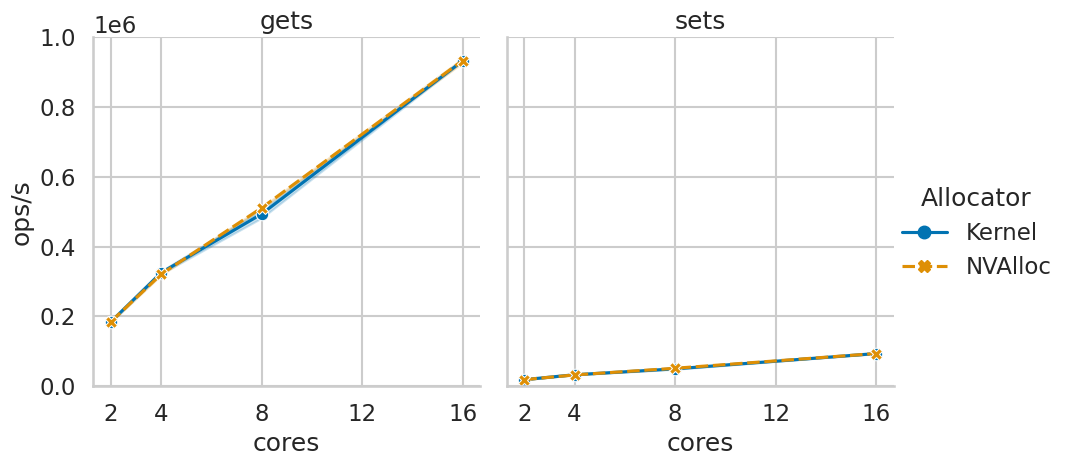

In [7]:
buddy_d = load(buddy)
buddy_d["alloc"] = "Kernel"
nvalloc_d = load(nvalloc)
nvalloc_d["alloc"] = "NVAlloc"

pgd = pd.concat([buddy_d, nvalloc_d], ignore_index=True)
pgd = pgd[["cores", "alloc", "gets", "sets", "iteration"]].melt(
    id_vars=["cores", "alloc", "iteration"],
    value_vars=["gets", "sets"], value_name="time")
# pgd = pgd.groupby(["cores", "alloc", "variable", "mem"]).min()
order = ["Kernel", "NVAlloc"]
g = sns.relplot(data=pgd, kind="line", x="cores", y="time",
                col="variable", style="alloc", hue="alloc", markers=True,
                style_order=order, hue_order=order)
g.set(xticks=[2, 4, 8, 12, 16])
g.set(ylim=(0, 1000000))
g.legend.set_title("Allocator")
g.set(ylabel="ops/s")
g.set(xlabel="cores")
g.set_titles("{col_name}")
